In [1]:
%matplotlib inline

In [2]:
from sparapy.radiosity_fast import DRadiosityFast
from sparapy.radiosity import Radiosity
import sparapy.geometry as geo
import sparapy as sp
import cProfile
from datetime import datetime
import numpy as np

sample_walls = [
    geo.Polygon(
        [[0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1]],
        [1, 0, 0], [0, 1, 0]),
    geo.Polygon(
        [[0, 1, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]],
        [1, 0, 0], [0, -1, 0]),
    geo.Polygon(
        [[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]],
        [1, 0, 0], [0, 0, 1]),
    geo.Polygon(
        [[0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]],
        [1, 0, 0], [0, 0, -1]),
    geo.Polygon(
        [[0, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0]],
        [0, 0, 1], [1, 0, 0]),
    geo.Polygon(
        [[1, 0, 0], [1, 0, 1], [1, 1, 1], [1, 1, 0]],
        [0, 0, 1], [-1, 0, 0]),
]




In [3]:
DRadiosityFast.from_polygon(sample_walls, 0.01)

In [4]:
cProfile.run('DRadiosityFast.from_polygon(sample_walls, 0.001)')

         63 function calls in 0.794 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.010    0.010    0.794    0.794 <string>:1(<module>)
        6    0.000    0.000    0.000    0.000 geometry.py:141(normal)
        6    0.000    0.000    0.000    0.000 geometry.py:146(size)
        6    0.000    0.000    0.000    0.000 geometry.py:156(center)
        6    0.000    0.000    0.000    0.000 geometry.py:50(calculate_center)
        6    0.000    0.000    0.000    0.000 geometry.py:54(calculate_size)
        1    0.784    0.784    0.784    0.784 radiosity_fast.py:223(process_patches)
        1    0.000    0.000    0.000    0.000 radiosity_fast.py:40(__init__)
        1    0.000    0.000    0.784    0.784 radiosity_fast.py:65(from_polygon)
        1    0.000    0.000    0.000    0.000 radiosity_fast.py:91(<listcomp>)
        1    0.000    0.000    0.000    0.000 radiosity_fast.py:92(<listcomp>)
        1    0.000   

In [5]:
# test for form factor
n_max = 9
fast_first = np.zeros((n_max))
fast_second = np.zeros((n_max))
slow = np.zeros((n_max))
number_of_patches = np.zeros((n_max))
repeat = 10
for i in range(n_max):
    max_size = 1/(2**i)
    print(f'run({i}/{n_max}): {max_size}')
    # run fast two times
    start = datetime.now()
    radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)
    fast_first[i] = (datetime.now() - start).microseconds
    start = datetime.now()
    for _ in range(repeat):
        radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)
    fast_second[i] = (datetime.now() - start).microseconds/repeat
    number_of_patches[i] = radiosity.n_patches
    # Run old
    # if max_size > 0.1:
    start = datetime.now()
    for _ in range(repeat):
        radiosity_old = Radiosity(sample_walls, max_size, 0, 1)
    slow[i] = (datetime.now() - start).microseconds/repeat

run(0/9): 1.0
run(1/9): 0.5
run(2/9): 0.25
run(3/9): 0.125
run(4/9): 0.0625
run(5/9): 0.03125
run(6/9): 0.015625
run(7/9): 0.0078125
run(8/9): 0.00390625


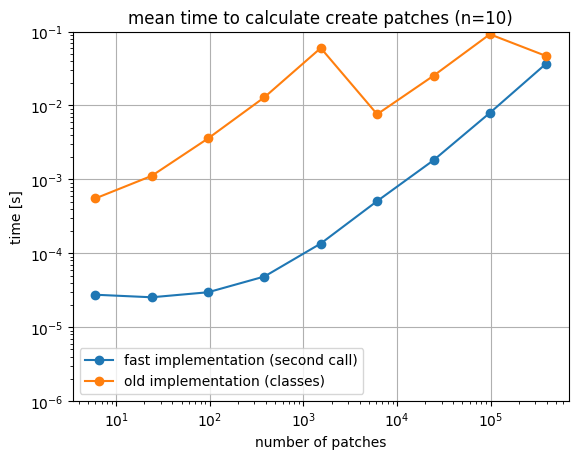

In [6]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.gca()
# ax.semilogy(number_of_patches, fast_first*1e-6, label='fast implementation (first call)')
ax.semilogy(number_of_patches, fast_second*1e-6, label='fast implementation (second call)', marker='o')
ax.semilogy(number_of_patches, slow*1e-6, label='old implementation (classes)', marker='o')
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('number of patches')
ax.set_ylabel('time [s]')
ax.set_title(f'mean time to calculate create patches (n={repeat})')
ax.set_ylim(1e-6, 1e-1)
plt.legend()
# note that the old implementation is also using numba code

In [7]:
# its x times faster for each setting
slow/fast_second

array([ 20.08      ,  43.88976378, 120.42760943, 266.01030928,
       441.17846608,  14.96200787,  13.90516101,  11.57443349,
         1.26414869])

In [8]:
fast_second*1e-6

array([2.75000e-05, 2.54000e-05, 2.97000e-05, 4.85000e-05, 1.35600e-04,
       5.08000e-04, 1.81360e-03, 7.93460e-03, 3.68656e-02])